In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib

In [5]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
data_path = os.path.join(parent_dir, 'data')
out_path = os.path.join(parent_dir, 'outputs')     # For the output

In [14]:


# Read the files
train = pd.read_csv(os.path.join(data_path, 'feature_engineered_data_final_v3.csv'))
labels = pd.read_csv(os.path.join(data_path, 'train_labels.csv'))

# Drop status_group if it already exists in train
if 'status_group' in train.columns:
    train = train.drop(columns=['status_group'])
# Merge training labels
df = pd.merge(train, labels, on='id')
print('Files successfully loaded and merged!')


Files successfully loaded and merged!


In [15]:
df = df.drop(columns=['region','lga', 'extraction_type', 'management']) #for now
df['water_quality_numeric'] = df['water_quality_numeric'].fillna(0)
df['water_risk_score_log'] = df['water_risk_score_log'].fillna(0)


In [16]:
#all categorical features (excluding target)
categorical_cols = df.select_dtypes(include='object').columns.tolist()
categorical_cols = [col for col in categorical_cols if col != 'status_group']

# One-hot encode medium-cardinality features (3 to 10 unique values)
onehot_cols = [col for col in categorical_cols if 2 < df[col].nunique() <= 10]
df_encoded = pd.get_dummies(df, columns=onehot_cols, drop_first=True)

# Label encode low-cardinality features (≤ 2 unique values)
label_enc_cols = [col for col in categorical_cols if df[col].nunique() <= 2]

label_encoders = {}
for col in label_enc_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df[col].astype(str)) 
    label_encoders[col] = le

In [9]:
df.to_csv(os.path.join(data_path, 'final_data.csv'), index=False)
print("Updated dataset saved as final_data.csv")

Updated dataset saved as final_data.csv


In [17]:
# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(df['status_group']) 

leak_cols = [col for col in df_encoded.columns if 'status_group_' in col or 'status_group.' in col]
df_encoded = df_encoded.drop(columns=leak_cols)

# Define features and target
X = df_encoded.drop(columns=['status_group','id'])
y = y_encoded

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [19]:
# pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000))
])

# Parameter grid
param_grid = {
    'logreg__C': [0.01, 0.1],
    'logreg__penalty': ['l2'],
    'logreg__solver': ['lbfgs', 'saga']
}

# Grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)  # this is essential

# Check best_estimator_
print(" Type:", type(grid_search))
print(" Best Estimator:", grid_search.best_estimator_)

# Save to file
joblib.dump(grid_search.best_estimator_, 'best_logistic_model.pkl')


 Type: <class 'sklearn.model_selection._search.GridSearchCV'>
 Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=0.01, max_iter=1000, solver='saga'))])


['best_logistic_model.pkl']

In [20]:
# Evaluate on the test set

y_test_pred = grid_search.best_estimator_.predict(X_test)

print(" Classification Report on Test Set:")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

print(" Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

 Classification Report on Test Set:
                         precision    recall  f1-score   support

             functional       0.71      0.91      0.79      6278
functional needs repair       0.62      0.03      0.06       786
         non functional       0.78      0.60      0.68      4454

               accuracy                           0.73     11518
              macro avg       0.71      0.51      0.51     11518
           weighted avg       0.73      0.73      0.70     11518

 Confusion Matrix:
[[5686    5  587]
 [ 610   25  151]
 [1750   10 2694]]


In [30]:
from sklearn import svm, neighbors, tree
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

# Train Models and Evaluate Accuracy Using Cross-Validation ===
mnnb = GaussianNB()
mnnb.fit(X_train, y_train)
guess_mnnb = cross_val_score(mnnb, X, y, cv=2)

knn = neighbors.KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
guess_knn = cross_val_score(knn, X, y, cv=2)

dtree = tree.DecisionTreeClassifier()
dtree.fit(X_train, y_train)
guess_tree = cross_val_score(dtree, X, y, cv=2)

svc = svm.LinearSVC(loss='hinge', tol=0.001, max_iter=2000)
svc.fit(X_train, y_train)
guess_svm = cross_val_score(svc, X, y, cv=2)


D:\script\Datacircle\water_pumps\.venv\lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\script\Datacircle\water_pumps\.venv\lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\script\Datacircle\water_pumps\.venv\lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [33]:
# Print Cross-Validation Accuracy Results 
model_names = ["SVM", "Naive Bayes", "KNN", "Decision Tree"]
varlist = [guess_svm, guess_mnnb, guess_knn, guess_tree]

print("Cross-Validation Accuracy:")
for name, scores in zip(model_names, varlist):
    print(f"{name}: {scores.mean():.2f} accuracy with a standard deviation of {scores.std():.2f}")


Cross-Validation Accuracy:
SVM: 0.61 accuracy with a standard deviation of 0.02
Naive Bayes: 0.53 accuracy with a standard deviation of 0.02
KNN: 0.69 accuracy with a standard deviation of 0.00
Decision Tree: 0.74 accuracy with a standard deviation of 0.00


In [35]:
# Make Predictions on the Test Set 
pred_svm = svc.predict(X_test)
pred_mnnb = mnnb.predict(X_test)
pred_knn = knn.predict(X_test)
pred_tree = dtree.predict(X_test)

# Print Confusion Matrices 
model_preds = {
    "SVM": pred_svm,
    "Naive Bayes": pred_mnnb,
    "KNN": pred_knn,
    "Decision Tree": pred_tree
}

print("\n Confusion Matrices on Test Set:\n")
for name, preds in model_preds.items():
    print(f"{name} Confusion Matrix:")
    print(confusion_matrix(y_test, preds))
    print('~' * 40)


 Confusion Matrices on Test Set:

SVM Confusion Matrix:
[[ 161    0 6117]
 [  11    0  775]
 [  19    0 4435]]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Naive Bayes Confusion Matrix:
[[3191 1806 1281]
 [ 176  421  189]
 [ 997 1166 2291]]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
KNN Confusion Matrix:
[[5099  136 1043]
 [ 453  150  183]
 [1576   80 2798]]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Decision Tree Confusion Matrix:
[[4973  342  963]
 [ 337  281  168]
 [ 922  148 3384]]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [39]:
# Save all  models
joblib.dump(svc, "svm_model.pkl")
joblib.dump(mnnb, "naive_bayes_model.pkl")
joblib.dump(knn, "knn_model.pkl")
joblib.dump(dtree, "decision_tree_model.pkl")

['decision_tree_model.pkl']

In [41]:
!pip install xgboost

You should consider upgrading via the 'D:\script\Datacircle\water_pumps\.venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [42]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    objective='multi:softmax',  # for multiclass classification
    num_class=3,                # 3 target classes
    eval_metric='mlogloss',     # suitable metric for classification
    use_label_encoder=False,
    random_state=42
)

xgb_model.fit(X_train, y_train)

D:\script\Datacircle\water_pumps\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [12:36:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=3, ...)

In [43]:
# saving the model
joblib.dump(xgb_model, "xgboost_model.pkl")

['xgboost_model.pkl']

In [44]:
pred_xgb = xgb_model.predict(X_test)

In [46]:
#Evaluation Performance of XGboost
print("XGBoost Classification Report:")
print(classification_report(y_test, pred_xgb, target_names=le.classes_))

print("XGBoost Confusion Matrix:")
print(confusion_matrix(y_test, pred_xgb))

XGBoost Classification Report:
                         precision    recall  f1-score   support

             functional       0.78      0.91      0.84      6278
functional needs repair       0.67      0.25      0.36       786
         non functional       0.84      0.74      0.79      4454

               accuracy                           0.80     11518
              macro avg       0.76      0.63      0.66     11518
           weighted avg       0.80      0.80      0.79     11518

XGBoost Confusion Matrix:
[[5703   66  509]
 [ 457  193  136]
 [1125   29 3300]]


In [48]:
# adding existing predictions in one dictionary
model_preds.update({
    "XGBoost": pred_xgb,
    "Logistic Regression": y_test_pred,
   })

In [63]:
comparison_data = [] 
for name, preds in model_preds.items():
    
    report = classification_report(y_test, preds, output_dict=True, zero_division=0)
    comparison_data.append({
        "Model": name,
        "Accuracy": report["accuracy"],
        "Macro Precision": report["macro avg"]["precision"],
        "Macro Recall": report["macro avg"]["recall"],
        "Macro F1": report["macro avg"]["f1-score"]
    })
comparison_df = pd.DataFrame(comparison_data)    

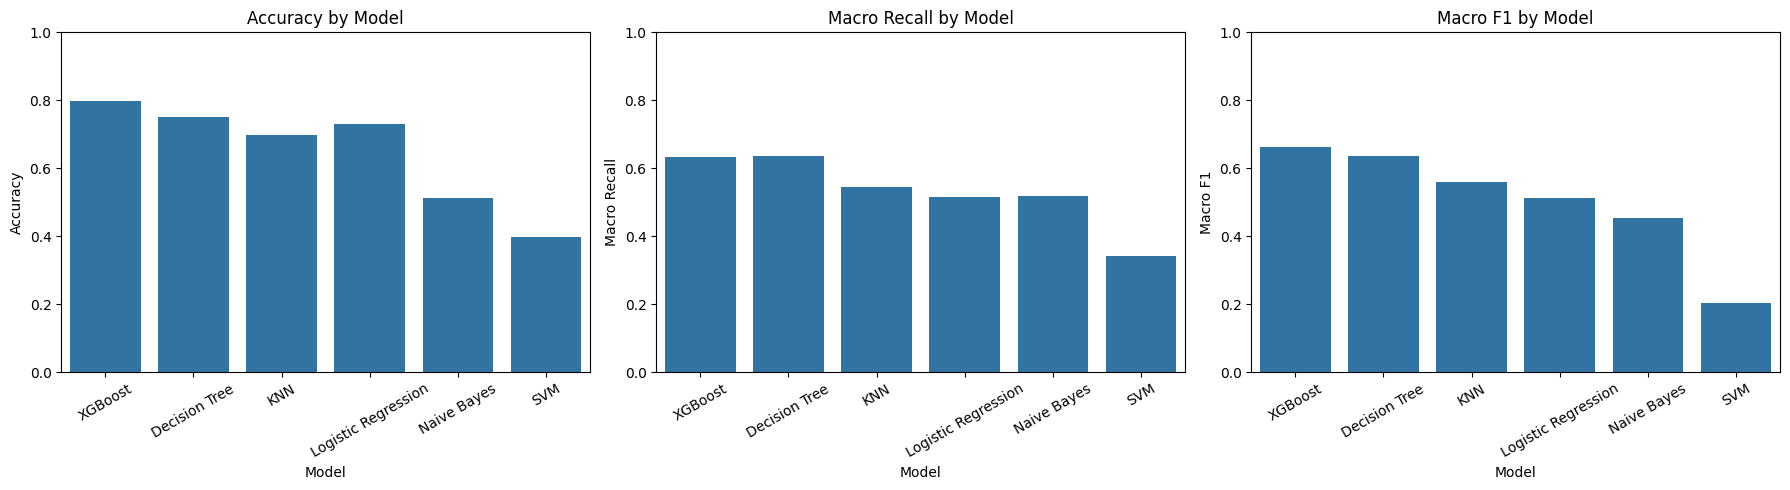

<Figure size 640x480 with 0 Axes>

In [75]:
#  Plot bar charts for metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
metrics = ["Accuracy", "Macro Recall", "Macro F1"]

for i, metric in enumerate(metrics):
    sns.barplot(data=comparison_df, x="Model", y=metric, ax=axes[i])
    axes[i].set_title(f"{metric} by Model")
    axes[i].set_ylim(0, 1)
    axes[i].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()
plt.savefig(os.path.join(data_path,"Plot_bar_charts.png"), dpi=300, bbox_inches='tight')



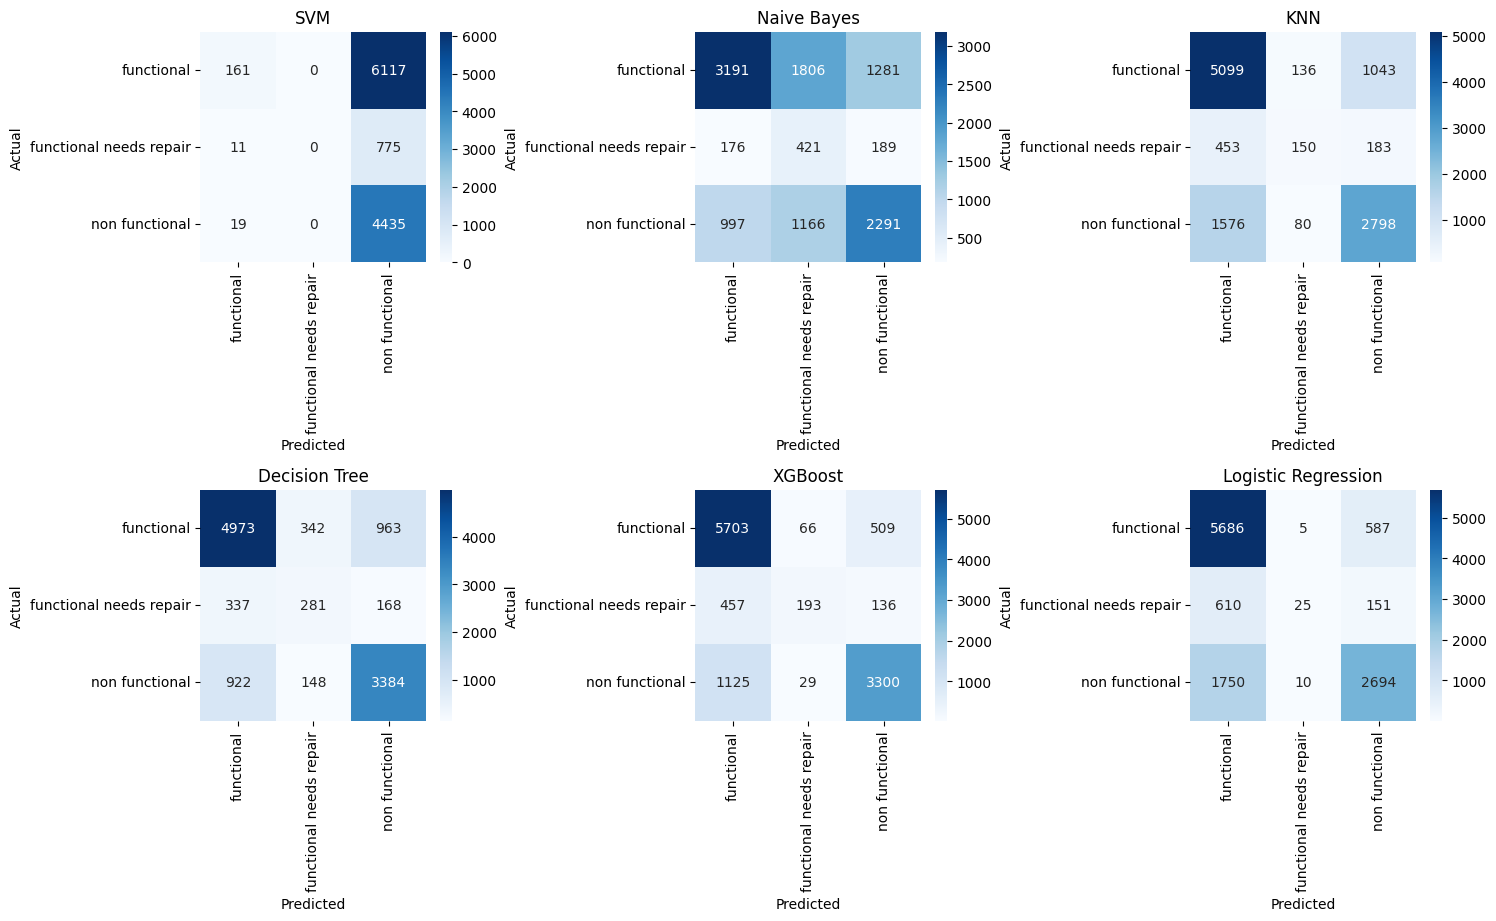

<Figure size 640x480 with 0 Axes>

In [76]:
# Plot confusion matrices as heatmaps
fig, axes = plt.subplots(3, 3, figsize=(15, 12))  # 3 rows × 3 columns
axes = axes.flatten()  # Flatten to 1D for easy indexing

class_labels = le.classes_

# Plot confusion matrices
for i, (name, preds) in enumerate(model_preds.items()):
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels, ax=axes[i])
    axes[i].set_title(name)
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

# Hide remaining empty subplots (if fewer than 9 models)
for j in range(len(model_preds), 9):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
plt.savefig(os.path.join(data_path,"confusion_matrices_grid.png"), dpi=300, bbox_inches='tight')


In [66]:
# Show the summary table
print(" Model Comparison Summary:")
print(comparison_df)

 Model Comparison Summary:
                 Model  Accuracy  Macro Precision  Macro Recall  Macro F1
0                  SVM  0.399028         0.411491      0.340460  0.203948
1          Naive Bayes  0.512502         0.488145      0.519425  0.452981
2                  KNN  0.698646         0.606837      0.543747  0.560394
3        Decision Tree  0.749957         0.637314      0.636468  0.636865
4              XGBoost  0.798403         0.763161      0.631621  0.662059
5  Logistic Regression  0.729727         0.705551      0.514120  0.512560


In [67]:
comparison_df.sort_values(by="Macro F1", ascending=False, inplace=True)
print("Ranked Models by Macro F1:")
print(comparison_df)

Ranked Models by Macro F1:
                 Model  Accuracy  Macro Precision  Macro Recall  Macro F1
4              XGBoost  0.798403         0.763161      0.631621  0.662059
3        Decision Tree  0.749957         0.637314      0.636468  0.636865
2                  KNN  0.698646         0.606837      0.543747  0.560394
5  Logistic Regression  0.729727         0.705551      0.514120  0.512560
1          Naive Bayes  0.512502         0.488145      0.519425  0.452981
0                  SVM  0.399028         0.411491      0.340460  0.203948


In [78]:
comparison_df.to_csv(os.path.join(data_path, 'Ranked_models_by_macro_F1.csv'), index=False)

###  Final Model Evaluation Summary


We evaluated several machine learning models to predict the functionality of water pumps in Tanzania, with a strong focus on identifying pumps that **need repair** (class 1), which is critical for field operations.

---

####  Models Compared:
- Support Vector Machine (SVM)
- Naive Bayes
- K-Nearest Neighbors (KNN)
- Decision Tree
- Logistic Regression
- XGBoost

---

####  Best All-Around Model: **Decision Tree**
- **Accuracy**: ~74%
- **Macro F1**: 0.64
- **Correctly predicted 275** repair cases (class 1)
- Better than XGBoost in detecting maintenance needs
- Simple, interpretable, and easy to deploy

---

####  Additional Insights:
- **Naive Bayes** correctly predicted **421** repair cases — the **highest recall for class 1**, but had **low precision** and **poor overall accuracy (~53%)**
- **XGBoost** had the best overall accuracy (**~80%**) and macro F1, but **missed many repair cases** (only 193 detected)

---

#### Strategic Recommendation:
- **Use Decision Tree** as the main model — strong balance between interpretability and detecting important cases
- Use **Naive Bayes as a backup detector** for class 1 to boost sensitivity
- Consider building a **hybrid or voting model** that gives extra weight to class 1 predictions from Naive Bayes

